In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy
from collections import OrderedDict
from tqdm import tqdm as tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import keras.backend as K
from keras.layers import Dense,Lambda
# from src.test_models.ops import *
from src.test_models.partials import GResNet
from src.test_models.crduplex import CRDuplex,CR_DAE
from src.test_models.CRD import CRD
from src.plot import plot_img_row

Using TensorFlow backend.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from src.data_generator import ShiftedDataBatcher

In [3]:
from keras.layers import Lambda,Conv2D,LeakyReLU,Input,BatchNormalization,Reshape
from keras.models import Model

def conv2d(input_, output_dim, k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02, name="conv2d"):
    conv_l = Conv2D(output_dim,kernel_size=(k_h,k_w),strides=(d_h,d_w),padding='SAME',name=name)
    
    
#         w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
#               initializer=tf.truncated_normal_initializer(stddev=stddev))
#         conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

#         biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
#         conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    return conv_l(input_)

def lrelu(input_,leak=0.2,name='lrelu'):
    layer = LeakyReLU(leak)
    return layer(input_)

def bn(x, is_training, scope):
    with tf.variable_scope(scope):
        layer = BatchNormalization(momentum=0.9,epsilon=1e-5)
        return layer(x)

def linear(input_, output_size, scope=None, k_init='glorot_uniform', bias_start='zeros', with_w=False):
    with tf.variable_scope(scope or "Linear"):
        layer = Dense(output_size,kernel_initializer=k_init,bias_initializer=bias_start)
        if with_w:
            return layer(input_), layer.get_weights()
        else:
            return layer(input_)

In [4]:
DB = ShiftedDataBatcher('fashion_mnist',scale=4,rotation=0.3,translation=0.75,flatten=False,bg='natural')

loading bsds500...


In [5]:
batches = DB.gen_test_batches(5,batch_size=2000)

In [6]:
X,y,meta = next(batches)

In [22]:
112/256*8

3.5

In [7]:
np.argmax(y)

0

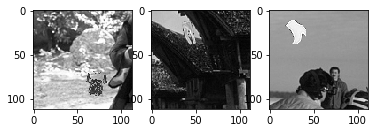

In [8]:
plot_img_row(X['whole'][:3])

In [9]:
pd.DataFrame.from_records(meta)

,category_id,category_name,dx,dy,image_id,object_name,rxy,tx,ty
0,0,T-shirt,57,63,4723,T-shirt0,-5,0.508929,441.0
1,1,Trouser,29,63,5845,Trouser1,15,0.258929,441.0
2,9,Ankle boot,14,63,5116,Ankle boot9,42,0.125000,441.0
3,2,Pullover,68,63,6574,Pullover2,32,0.607143,441.0
4,7,Sneaker,44,63,7566,Sneaker7,-28,0.392857,441.0
5,6,Dress Shirt,20,63,4763,Dress Shirt6,-8,0.178571,441.0
6,5,Sandal,59,63,5139,Sandal5,-27,0.526786,441.0
7,1,Trouser,69,63,8309,Trouser1,0,0.616071,441.0
8,3,Dress,40,63,7925,Dress3,-12,0.357143,441.0
9,0,T-shirt,36,63,2677,T-shirt0,3,0.321429,441.0


In [10]:
from keras.layers import Add,Conv2D

In [11]:
mod = CRD(input_shape=(112,112,1),output_shape=(112,112,1),n_residual_blocks=4,recon=100)
# G =GResNet(img_shape=[56,56,1],y_dim=500,n_residual_blocks=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/home/elijahc/.pyenv/versions/fastai/lib/python3.6/site-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [12]:
mod.EG.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        (None, 112, 112, 1)  0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 500)          3234100     model_input[0][0]                
__________________________________________________________________________________________________
Generator (Model)               (None, 112, 112, 1)  412129      Encoder[1][0]                    
__________________________________________________________________________________________________
Classifier (Model)              (None, 10)           3299518     model_input[0][0]                
Total params: 3,711,647
Trainable params: 3,711,103
Non-trainable params: 544
_______________________________

In [13]:
test_batch = DB.gen_test_batches(1)
train_batches = DB.gen_train_batches(10000)
i=0

In [14]:
X,Xfg,Xsm,y = next(test_batch)
y_tr = K.variable(Xfg)

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
tr_y.shape

In [ ]:
p_recon,p_class = mod.EG.predict_on_batch(X)

In [ ]:
mod.EGD.test_on_batch([X,Xfg],y=[np.arange(DB.batch_size),np.arange(DB.batch_size),y]) 

In [ ]:
hist_labels = ['loss','G_loss','C_loss','G_mse','acc']

with tqdm(train_batches,total=10000,initial=i) as logger:
    for X,Xfg,Xsm,tr_y in logger:
        r = mod.combined.train_on_batch([X,Xfg],y={'Classifier':tr_y,'Generator':Xfg,'Discriminator':Xsm})
        r = {k:v for k,v in zip(hist_labels,r)}
        logger.set_postfix(**r)
        

In [ ]:
class VGAN(object):
    
    def __init__(self,batch_size,z_dim):
        self.batch_size = batch_size
        self.z_dim = z_dim
        self.input_height = 28
        self.input_width = 28
        self.c_dim = 1
    
    def encoder(self,x, is_training=True, reuse=False):
        with tf.variable_scope("encoder", reuse=reuse):
            net = tf.nn.relu(bn(linear(x, 3000, scope='e_fc1')))
            net = tf.nn.relu(bn(linear(net, 2000, scope='e_fc2')))
            e_out = tf.nn.relu(bn(linear(net, self.z_dim+self.y_dim, scope='e_fc3')))
            
            z_out, y_out = Lambda(lambda merge,z_dim:[merge[:,:z_dim],merge[:,z_dim:]],
                                  arguments={'z_dim':self.z_dim})(e_out)
            
            return z_out,y_out
    
    def generator(self, z, y, is_training=True, reuse=False):
        with tf.variable_scope("generator", reuse=reuse):

            # merge z and code
            z = concat([z, y], 1)

            net = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
            net = tf.nn.relu(bn(linear(net, 128 * 7 * 7, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
            net = tf.reshape(net, [self.batch_size, 7, 7, 128])
            net = tf.nn.relu(
                bn(deconv2d(net, [self.batch_size, 14, 14, 64], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
                   scope='g_bn3'))

            out = tf.nn.sigmoid(deconv2d(net, [self.batch_size, 28, 28, 1], 4, 4, 2, 2, name='g_dc4'))

            return out
        
    def build_model(self):
        
        image_dims = [self.input_height*self.input_width, self.c_dim]

        bs = self.batch_size
        
        """ Graph Input """
        # images
        self.inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')

        # labels
#         self.y = tf.placeholder(tf.float32, [bs, self.y_dim], name='y')
        E = self.encoder(self.inputs, is_training=True, reuse=True)

        # noises
        self.z = tf.placeholder(tf.float32, [bs, self.z_dim], name='z')
        
        G = self.generator(self.z, self.y, is_training=True, reuse=False)


In [ ]:
# mod = VGAN(batch_size=64,z_dim=10)

In [ ]:
# mod.build_model()